In [29]:
import csv
import numpy as np
import pandas as pd
import utils 
import seaborn as sns

from scipy.optimize import minimize, LinearConstraint
from scipy.special import softmax

import matplotlib.pyplot as plt

In [138]:
data = np.genfromtxt('data_new.csv', delimiter=',', dtype=str)
data = np.delete(data, 0, 0)

new_data = []

# turn each game into entry in this array

def remove_blank(l):
    return list(filter(lambda a: a != '', l))

def replace_letters(l):
   return [[1,0] if x=='c' else [0, 1] for x in l]

for i in range(0, data.shape[0], 2):
    p1 = data[i]
    p2 = data[i+1]

    game = int(p1[0])
    player1 = p1[2]
    player2 = p2[2]
    p1_actions = np.array(replace_letters(remove_blank(p1[3:]))).T
    p2_actions =  np.array(replace_letters(remove_blank(p2[3:]))).T
   
    actions =  [p1_actions, p2_actions]

    new_data.append([game, player1, player2, actions])
df = pd.DataFrame(new_data)
df.columns = ['Game', 'Player_1', 'Player_2', 'Actions']
data = list(df.Actions)

In [163]:
from utils import expected_utility

payoffs = np.zeros([2, 2, 2])
payoffs[0, :, :] = np.array([[0, -1],
                             [1, -2 ]])

def compute_quantal_regret(play, possible_values, lambda_, h=2):
    thetas = (np.arange(0,101)/100 * (possible_values[1]- possible_values[0])) + possible_values[0]
    num_actions = play[0].shape[0]
    len_play =  play[0].shape[1]
    all_regrets = []
    estimates = np.zeros(2)

    for player in range(2):
        regrets = np.zeros((len(thetas)))
        for theta_i, theta in enumerate(thetas):
            payoffs_theta = np.copy(payoffs)
            payoffs_theta[1, 1] =  payoffs_theta[1, 1] + theta

            # compute empirical utility player i got
            empirical_utility = 0 
            for l in range(len_play):
                a_i = play[player][:, l]
                a_other = play[1-player][:, l]
                empirical_utility += expected_utility([a_i, a_other], payoffs_theta)

            # compute utility as it player i played action
            fixed_action_utils = np.zeros(2)
            for action in range(num_actions):
                a_i = np.zeros(2)
                a_i[action] = 1

                for l in range(len_play):
                    a_other = play[1-player][:, l]
                    fixed_action_utils[action] += expected_utility([a_i, a_other], payoffs_theta)

            regrets[theta_i] = (np.max(fixed_action_utils) - empirical_utility)/len_play

        # what to find a better way to determine lambda

        
        all_regrets.append(regrets) 
        weights = np.e**(regrets* -lambda_)
        theta_hat = np.dot(thetas, weights)/np.sum(weights)
        estimates[player] = theta_hat

    # what was the players regret at each iteration under the estimate? 
    regret_over_time_all = []
    for player in range(2):
        payoffs_theta = np.copy(payoffs)
        payoffs_theta[1, 1] =  payoffs_theta[1, 1] + estimates[player]       
        
        empirical_utility = np.zeros(len_play)
        regrets = np.zeros((num_actions, len_play)) # regret at each iterations
        for l in range(len_play):
            a_i = play[player][:, l]
            a_other = play[1-player][:, l]
           
            empirical_utility[l] = expected_utility([a_i, a_other], payoffs_theta)

            for action in range(num_actions):
                a_i = np.zeros(2)
                a_i[action] = 1
                regrets[action, l] = expected_utility([a_i, a_other], payoffs_theta)

        regret_over_time = np.zeros(len_play)
        
        # print(empirical_utility)

        for t in range(1, len_play+1):
            start = max(0, t-h)
            # print("regreat at time {}".format(t))
            # print(regrets[:, :t])
            # print(np.sum(regrets[:, :t], axis=1))
            # print(np.sum(empirical_utility[:t]))
            regret_over_time[t-1] = (np.max( np.sum(regrets[:,  start:t], axis=1)) - np.sum(empirical_utility[ start:t]))/ (t-start)

        # print("erere")
        # print(regret_over_time)
        regret_over_time_all.append(regret_over_time)



    return estimates,  regret_over_time_all

In [140]:
data[1]

[array([[1, 0, 0],
        [0, 1, 1]]),
 array([[1, 1, 0],
        [0, 0, 1]])]

In [141]:
compute_quantal_regret(data[1], [-2, 2], lambda_=1)

(array([ 0.03485223, -0.03485223]),
 [array([1.03485223, 0.51742611, 0.        ]),
  array([0.96514777, 0.        , 0.34495074])])

In [164]:
estimates = np.zeros((2, len(data)))

regrets = np.zeros(14)
counts = np.zeros(14)

for i, play in enumerate(data):
    estimates[:, i], regrets_=  compute_quantal_regret(play, [-2, 2], lambda_=1, h=20)

    for reg in regrets_:
        for r_idx, r in enumerate(reg):
            regrets[r_idx] += r
            counts[r_idx] +=1

        regrets_[:]

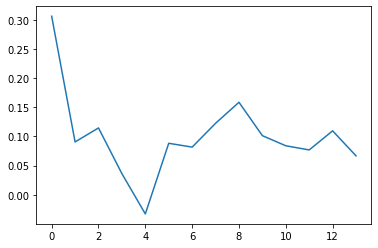

In [165]:
plt.plot(regrets/counts)

In [170]:
estimates = np.zeros((2, len(data)))

regrets = np.zeros(14)
counts = np.zeros(14)

for i, play in enumerate(data):
    estimates[:, i], regrets_=  compute_quantal_regret(play, [-2, 2], lambda_=0.5, h=2)

    for reg in regrets_:
        for r_idx, r in enumerate(reg):
            regrets[r_idx] += r
            counts[r_idx] +=1

        regrets_[:]

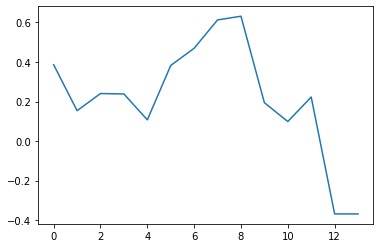

In [171]:
plt.plot(regrets/counts)

(array([[0., 0., 0., 2., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 0., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]]),
 array([-0.30831409, -0.22642813, -0.14454217, -0.06265621,  0.01922975,
         0.10111571,  0.18300168,  0.26488764,  0.3467736 ,  0.42865956,
         0.51054552]),
 <a list of 14 BarContainer objects>)

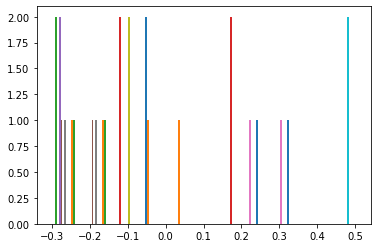

In [110]:
plt.hist(estimates)